# Data Preprocessing Using Pipeline and Transformers

![](./images/transformers.jpg)

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
path_to_data = os.path.join('.','data','kc_house_data.csv')

house_data = pd.read_csv(path_to_data)

house_data.tail(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21603,7852140040,20140825T000000,507250.0,3,2.50,2270,5536,2.0,0,0,...,8,2270,0,2003,0,98065,47.5389,-121.881,2270,5731
21604,9834201367,20150126T000000,429000.0,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21605,3448900210,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
21606,7936000429,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
21607,2997800021,20150219T000000,475000.0,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [3]:
house_data.shape

(21613, 21)

In [4]:
house_data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## Categorical

- date : The dates in this column are of the format ‘YYYYMMDDT000000’ and must be cleaned and processed to be used in any meaningful way.

In [5]:
house_data.waterfront.unique()

array([0, 1], dtype=int64)

- waterfront : Wether the house is waterfront property or not. Convert to binary — Yes or No

In [6]:
house_data.view.unique()

array([0, 3, 4, 2, 1], dtype=int64)

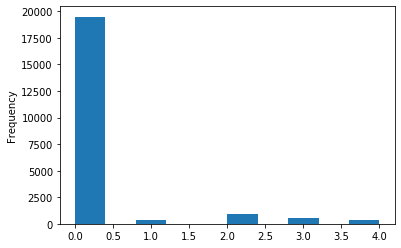

In [12]:
house_data['view'].plot(kind='hist')

- view : How many times the house has been viewed. Most of the values are 0. The rest are very thinly spread between 1 and 4. Convert to Binary — Yes or No

In [13]:
house_data.yr_renovated.unique()

array([   0, 1991, 2002, 2010, 1999, 1992, 2013, 1994, 1978, 2005, 2008,
       2003, 1984, 1954, 2014, 2011, 1974, 1983, 1945, 1990, 1988, 1957,
       1977, 1981, 1995, 2000, 1998, 1970, 1989, 2004, 1986, 2009, 2007,
       1987, 1973, 2006, 1985, 2001, 1980, 1971, 1979, 1997, 1950, 1969,
       1948, 2015, 1968, 2012, 1963, 1951, 1993, 1962, 1996, 1972, 1953,
       1955, 1982, 1956, 1940, 1976, 1946, 1975, 1958, 1964, 1959, 1960,
       1967, 1965, 1934, 1944], dtype=int64)

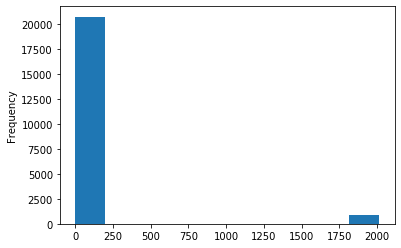

In [14]:
house_data['yr_renovated'].plot(kind='hist')

In [15]:
house_data.yr_renovated.value_counts()

0       20699
2014       91
2013       37
2003       36
2000       35
        ...  
1934        1
1959        1
1951        1
1948        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

- yr_renovated : The year the house was renovated in. Most of the values are 0, presumably for never while the rest are very thinly spread between some years. Convert to Binary — Yes or No

In [49]:
# construisons un Transformateur qui extrait les colonnes passées en argument à son constructeur
# renvoie un bloc de données pandas avec uniquement les colonnes sélectionnées
class ColumExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_names):
        
        self._feature_names = feature_names
        
    def fit(self, X, y=None):
        
        return self
    
    def transform(self, X, y=None):
        
        return X[self._feature_names]
        


In [50]:
#Custom transformer that breaks dates column into year, month and day into separate columns and
#converts certain features to binary 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self, use_dates = ['year', 'month', 'day'] ):
        self._use_dates = use_dates
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self

    #Helper function to extract year from column 'dates' 
    def get_year( self, obj ):
        return str(obj)[:4]
    
    #Helper function to extract month from column 'dates'
    def get_month( self, obj ):
        return str(obj)[4:6]
    
    #Helper function to extract day from column 'dates'
    def get_day(self, obj):
        return str(obj)[6:8]
    
    #Helper function that converts values to Binary depending on input 
    def create_binary(self, obj):
        if obj == 0:
            return 'No'
        else:
            return 'Yes'
    
    #Transformer method we wrote for this transformer 
    #Depending on constructor argument break dates column into specified units
       #using the helper functions written above 
        #Drop unusable column
        #Convert these columns to binary for one-hot-encoding later
        #returns numpy array
    def transform(self, X , y = None ):
        
        for spec in self._use_dates:
            exec( "X.loc[:,'{}'] = X['date'].apply(self.get_{})".format( spec, spec ) )
        X = X.drop('date', axis = 1 )
        X.loc[:,'waterfront'] = X['waterfront'].apply( self.create_binary )
        X.loc[:,'view'] = X['view'].apply( self.create_binary )
        X.loc[:,'yr_renovated'] = X['yr_renovated'].apply( self.create_binary )
        return X.values 

## Numerical

In [20]:
house_data.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
8       13
0       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

- bedrooms : Number of bedrooms in the house. 

In [21]:
house_data.bathrooms.value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
8.00       2
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [24]:
house_data.groupby('bedrooms')['bathrooms'].count()

bedrooms
0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
33       1
Name: bathrooms, dtype: int64

- bathrooms : Number of bathrooms in the house. The constructor for this transformer will have a parameter ‘bath_per_bead’ that takes in a Boolean value. If True, then the constructor will create a new column by computing bathrooms/bedrooms to calculate the number of bathrooms per bedroom and drop the original bathroom column. If False, then it will just pass the bathroom column as it is.

- sqft_living : Size of the living area of the house in square feet. Pass as it is.
- sqft_lot : Total size of the lot in square feet. Pass as it is.
- floors : Number of floors in the house. Pass as it is.
- condition : Discrete variable describing the condition of the house with values from 1–5. Pass as it is.
- grade : Overall grade given to the housing unit, based on King County grading system with values from 1–13. Pass as it is.
- sqft_basement : Size of the basement in the house in square feet if any. 0 for houses that don’t have basements. Pass as it is.
- yr_built : The year the house was built in. The constructor for this yr_built : The year the house was built in. The constructor for this transformer will have another parameter ‘years_old’ that also takes in a Boolean value. If True, then the constructor will create a new column by computing the age of the house in 2019 by the subtracting the year it was built in from 2019 and it will drop the original yr_built column. If False, then it will just pass the yr_built column as it is.

In [40]:
house_data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [35]:
np.isinf(house_data['grade']).unique()

array([False])

In [58]:
class NumericalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, bath_per_bead = True, years_old = True):
        
        self._bath_per_bead = bath_per_bead
        self._years_old = years_old
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X, y = None):
        
        if self._bath_per_bead:
            X.loc[:,'bath_per_bead'] = X['bathrooms']/ X['bedrooms']
            X.drop(['bedrooms'], axis=1)
            
        if self._years_old:
            X.loc[:,'years_old'] = 2019 - X['yr_built']
            
            X.drop(['yr_built'], axis=1)
            
            X = X.replace( [ np.inf, -np.inf ], np.nan )
        return X.values
            
        
        
        
        

In [52]:
# categorical features

CATS_FEAT = ['date','waterfront','view', 'yr_renovated']

# Numerical features
NUMS_FEAT = ['bedrooms','bathrooms','sqft_living', 'sqft_lot', 'floors','condition', 'grade', 'sqft_basement', 'yr_built']

In [62]:
#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', ColumExtractor(CATS_FEAT) ),
                                  
                                  ( 'cat_transformer', CategoricalTransformer(use_dates = ['year', 'month', 'day'] ) ), 
                                  
                                  ( 'one_hot_encoder', OneHotEncoder( sparse = False ) ) ] )

#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', ColumExtractor(NUMS_FEAT) ),
                                  
                                  ( 'num_transformer', NumericalTransformer() ),
                                  
                                  ('imputer', SimpleImputer(strategy = 'median') ),
                                        ( 'std_scaler', StandardScaler())
                                  
                                   ] )



#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )





L'objet FeatureUnion accepte des objets de pipeline contenant uniquement des transformateurs. Un modèle d'apprentissage automatique est un estimateur.

On peut créer un autre objet Pipeline et passer l'objet pipeline complet comme première étape et ajouter un modèle d'apprentissage automatique comme étape finale.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Leave it as a dataframe becuase our pipeline is called on a 
#pandas dataframe to extract the appropriate columns, remember?
X = house_data.drop('price', axis = 1)
#You can covert the target variable to numpy 
y = house_data['price'].values 

X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )

#The full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),
                                     
                                  
                                  ( 'model', LinearRegression() ) ] )

#Can call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

#Can predict with it like any other pipeline
y_pred = full_pipeline_m.predict( X_test ) 

C:\Users\ASSAHOUA JOSEPH\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ASSAHOUA JOSEPH\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ASSAHOUA JOSEPH\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [65]:
print(full_pipeline_m.score(X_test, y_test))

0.6520823228603883


C:\Users\ASSAHOUA JOSEPH\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\ASSAHOUA JOSEPH\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\ASSAHOUA JOSEPH\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

Nous adaptons simplement le pipeline sur un ensemble de données non traité et il automatise tout le prétraitement et l'adaptation avec les outils que nous avons créés.

Les colonnes appropriées sont divisées, puis elles sont poussées vers le bas des pipelines appropriés où elles passent par 3 ou 4 transformateurs différents chacune (7 au total!) Avec des arguments que nous décidons 

Et les données prétraitées sont remontées et poussées vers le bas le modèle pour la formation! 

L'appel de Predict fait la même chose pour la trame de données de test non traitée et renvoie les prédictions! Voici un schéma simple qui montre le flux de notre pipeline d'apprentissage automatique.

![](./images/sans-titre.png)